# 03 - EDA: Card Analysis

**Purpose**: Analyze individual cards and deck compositions.

**Key Questions**:
- Which cards have the highest win rates?
- Are evolution cards dominant?
- What card pairs appear together frequently (synergy)?
- How does rarity affect win rates?
- What's the optimal average elixir cost?

**High-Impact Analysis**:
- Card synergy network (pairs with high lift metric)
- Counter-meta discovery (underused cards that beat popular ones)
- Deck archetype clustering

In [1]:
import sys, os, duckdb, pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, os.path.join(PROJECT_ROOT, 'src'))

# Use Parquet if available (faster), fallback to CSV
DATA_PATH = os.path.join(PROJECT_ROOT, 'battles.parquet')
if not os.path.exists(DATA_PATH):
    DATA_PATH = os.path.join(PROJECT_ROOT, 'battles.csv')

from duckdb_utils import get_connection, create_battles_view, query_to_df, save_to_parquet
from visualization import setup_presentation_style, plot_win_rate_comparison
from feature_engineering import get_card_synergy_pairs, calculate_lift

con = get_connection()
create_battles_view(con, DATA_PATH)
setup_presentation_style()

✓ Created view 'battles' from Parquet: c:\Users\Danny\Documents\GitHub\HeHeHaHa_DataRoyale\battles.parquet
✓ Presentation style configured


In [2]:
# Load card ID to name mapping from artifacts/cards.json
import json

cards_json_path = os.path.join(PROJECT_ROOT, 'artifacts', 'cards.json')
with open(cards_json_path, 'r') as f:
    cards_data = json.load(f)

# Create card_id → card_name dictionary
card_id_to_name = {card['id']: card['name'] for card in cards_data}
print(f"✓ Loaded {len(card_id_to_name):,} card names from artifacts/cards.json")

# Helper function to map card IDs to names
def map_card_ids(df, card_id_cols):
    """
    Add card name columns to a DataFrame for specified card ID columns.
    
    Parameters:
    - df: pandas DataFrame
    - card_id_cols: list of column names containing card IDs
    
    Returns:
    - df with new *_name columns appended
    """
    df_copy = df.copy()
    for col in card_id_cols:
        if col in df_copy.columns:
            name_col = col.replace('_id', '_name').replace('.id', '_name')
            df_copy[name_col] = df_copy[col].map(card_id_to_name).fillna(f'Unknown ({df_copy[col]})')
    return df_copy

# Helper function to assign trophy brackets (reuse from notebook 02)
def assign_trophy_bracket(trophies_series):
    """
    Assign trophy bracket labels based on trophy counts.
    Brackets: 0-1000, 1000-2000, 2000-3000, 3000-4000, 4000-5000, 5000-6000, 6000-7000, 7000+
    """
    return pd.cut(
        trophies_series,
        bins=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, float('inf')],
        labels=['0-1k', '1k-2k', '2k-3k', '3k-4k', '4k-5k', '5k-6k', '6k-7k', '7k+'],
        right=False
    )

print("✓ Helper functions created: map_card_ids(), assign_trophy_bracket()")

✓ Loaded 120 card names from artifacts/cards.json
✓ Helper functions created: map_card_ids(), assign_trophy_bracket()


# Calculate individual card win rates
# Union all winner and loser cards across all 8 card slots
print("Calculating individual card win rates...")
card_win_rates = query_to_df(con, """
    WITH card_usage AS (
        -- Winner cards (won=1)
        SELECT "winner.card1.id" as card_id, 1 as won FROM battles WHERE "winner.card1.id" IS NOT NULL
        UNION ALL SELECT "winner.card2.id" as card_id, 1 as won FROM battles WHERE "winner.card2.id" IS NOT NULL
        UNION ALL SELECT "winner.card3.id" as card_id, 1 as won FROM battles WHERE "winner.card3.id" IS NOT NULL
        UNION ALL SELECT "winner.card4.id" as card_id, 1 as won FROM battles WHERE "winner.card4.id" IS NOT NULL
        UNION ALL SELECT "winner.card5.id" as card_id, 1 as won FROM battles WHERE "winner.card5.id" IS NOT NULL
        UNION ALL SELECT "winner.card6.id" as card_id, 1 as won FROM battles WHERE "winner.card6.id" IS NOT NULL
        UNION ALL SELECT "winner.card7.id" as card_id, 1 as won FROM battles WHERE "winner.card7.id" IS NOT NULL
        UNION ALL SELECT "winner.card8.id" as card_id, 1 as won FROM battles WHERE "winner.card8.id" IS NOT NULL
        UNION ALL
        -- Loser cards (won=0)
        SELECT "loser.card1.id" as card_id, 0 as won FROM battles WHERE "loser.card1.id" IS NOT NULL
        UNION ALL SELECT "loser.card2.id" as card_id, 0 as won FROM battles WHERE "loser.card2.id" IS NOT NULL
        UNION ALL SELECT "loser.card3.id" as card_id, 0 as won FROM battles WHERE "loser.card3.id" IS NOT NULL
        UNION ALL SELECT "loser.card4.id" as card_id, 0 as won FROM battles WHERE "loser.card4.id" IS NOT NULL
        UNION ALL SELECT "loser.card5.id" as card_id, 0 as won FROM battles WHERE "loser.card5.id" IS NOT NULL
        UNION ALL SELECT "loser.card6.id" as card_id, 0 as won FROM battles WHERE "loser.card6.id" IS NOT NULL
        UNION ALL SELECT "loser.card7.id" as card_id, 0 as won FROM battles WHERE "loser.card7.id" IS NOT NULL
        UNION ALL SELECT "loser.card8.id" as card_id, 0 as won FROM battles WHERE "loser.card8.id" IS NOT NULL
    )
    SELECT 
        card_id,
        COUNT(*) as usage_count,
        SUM(won) as win_count,
        AVG(won) as win_rate
    FROM card_usage
    WHERE card_id IS NOT NULL
    GROUP BY card_id
    HAVING COUNT(*) >= 1000  -- Minimum usage threshold for statistical significance
    ORDER BY usage_count DESC
""")

# Add card names
card_win_rates = map_card_ids(card_win_rates, ['card_id'])

print(f"✓ Calculated win rates for {len(card_win_rates):,} cards")
print(f"\nTop 10 Cards by Usage:")
print(card_win_rates[['card_name', 'usage_count', 'win_rate', 'win_count']].head(10).to_string(index=False))
print(f"\nTop 10 Cards by Win Rate:")
top_wr = card_win_rates.sort_values('win_rate', ascending=False).head(10)
print(top_wr[['card_name', 'usage_count', 'win_rate', 'win_count']].to_string(index=False))
print(f"\nBottom 10 Cards by Win Rate:")
bottom_wr = card_win_rates.sort_values('win_rate', ascending=True).head(10)
print(bottom_wr[['card_name', 'usage_count', 'win_rate', 'win_count']].to_string(index=False))

# Visualize card win rates
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: Top 20 cards by win rate
top_20_wr = card_win_rates.sort_values('win_rate', ascending=False).head(20)
axes[0, 0].barh(range(len(top_20_wr)), top_20_wr['win_rate'] * 100, color='darkgreen', alpha=0.7)
axes[0, 0].set_yticks(range(len(top_20_wr)))
axes[0, 0].set_yticklabels(top_20_wr['card_name'], fontsize=10)
axes[0, 0].axvline(50.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='50% (Balanced)')
axes[0, 0].set_xlabel('Win Rate (%)', fontsize=12)
axes[0, 0].set_title('Top 20 Cards by Win Rate', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].legend()
axes[0, 0].grid(axis='x', alpha=0.3)

# Plot 2: Bottom 20 cards by win rate
bottom_20_wr = card_win_rates.sort_values('win_rate', ascending=True).head(20)
axes[0, 1].barh(range(len(bottom_20_wr)), bottom_20_wr['win_rate'] * 100, color='darkred', alpha=0.7)
axes[0, 1].set_yticks(range(len(bottom_20_wr)))
axes[0, 1].set_yticklabels(bottom_20_wr['card_name'], fontsize=10)
axes[0, 1].axvline(50.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='50% (Balanced)')
axes[0, 1].set_xlabel('Win Rate (%)', fontsize=12)
axes[0, 1].set_title('Bottom 20 Cards by Win Rate', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].legend()
axes[0, 1].grid(axis='x', alpha=0.3)

# Plot 3: Win rate distribution
axes[1, 0].hist(card_win_rates['win_rate'] * 100, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(50.0, color='red', linestyle='--', linewidth=2, label='50% (Balanced)')
axes[1, 0].axvline(card_win_rates['win_rate'].mean() * 100, color='orange', linestyle='--', linewidth=2, 
                   label=f'Mean: {card_win_rates["win_rate"].mean()*100:.2f}%')
axes[1, 0].set_xlabel('Win Rate (%)', fontsize=12)
axes[1, 0].set_ylabel('Number of Cards', fontsize=12)
axes[1, 0].set_title('Distribution of Card Win Rates', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: Usage vs win rate scatter
axes[1, 1].scatter(card_win_rates['usage_count'], card_win_rates['win_rate'] * 100, 
                  alpha=0.6, s=80, c=card_win_rates['win_rate']*100, cmap='RdYlGn', 
                  edgecolors='black', linewidth=0.5, vmin=40, vmax=60)
axes[1, 1].axhline(50.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='50% (Balanced)')
axes[1, 1].set_xlabel('Usage Count (log scale)', fontsize=12)
axes[1, 1].set_ylabel('Win Rate (%)', fontsize=12)
axes[1, 1].set_title('Card Usage vs Win Rate', fontsize=14, fontweight='bold')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)
cbar = plt.colorbar(axes[1, 1].collections[0], ax=axes[1, 1])
cbar.set_label('Win Rate (%)', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n📊 Card Win Rate Summary:")
print(f"  • Mean win rate: {card_win_rates['win_rate'].mean()*100:.2f}%")
print(f"  • Median win rate: {card_win_rates['win_rate'].median()*100:.2f}%")
print(f"  • Std dev: {card_win_rates['win_rate'].std()*100:.2f}%")
print(f"  • Cards above 52% win rate: {len(card_win_rates[card_win_rates['win_rate'] > 0.52]):,}")
print(f"  • Cards below 48% win rate: {len(card_win_rates[card_win_rates['win_rate'] < 0.48]):,}")

In [3]:
# Calculate individual card win rates
# Union all winner and loser cards across all 8 card slots
print("Calculating individual card win rates...")
card_win_rates = query_to_df(con, """
    WITH card_usage AS (
        -- Winner cards (won=1)
        SELECT "winner.card1.id" as card_id, 1 as won FROM battles WHERE "winner.card1.id" IS NOT NULL
        UNION ALL SELECT "winner.card2.id" as card_id, 1 as won FROM battles WHERE "winner.card2.id" IS NOT NULL
        UNION ALL SELECT "winner.card3.id" as card_id, 1 as won FROM battles WHERE "winner.card3.id" IS NOT NULL
        UNION ALL SELECT "winner.card4.id" as card_id, 1 as won FROM battles WHERE "winner.card4.id" IS NOT NULL
        UNION ALL SELECT "winner.card5.id" as card_id, 1 as won FROM battles WHERE "winner.card5.id" IS NOT NULL
        UNION ALL SELECT "winner.card6.id" as card_id, 1 as won FROM battles WHERE "winner.card6.id" IS NOT NULL
        UNION ALL SELECT "winner.card7.id" as card_id, 1 as won FROM battles WHERE "winner.card7.id" IS NOT NULL
        UNION ALL SELECT "winner.card8.id" as card_id, 1 as won FROM battles WHERE "winner.card8.id" IS NOT NULL
        UNION ALL
        -- Loser cards (won=0)
        SELECT "loser.card1.id" as card_id, 0 as won FROM battles WHERE "loser.card1.id" IS NOT NULL
        UNION ALL SELECT "loser.card2.id" as card_id, 0 as won FROM battles WHERE "loser.card2.id" IS NOT NULL
        UNION ALL SELECT "loser.card3.id" as card_id, 0 as won FROM battles WHERE "loser.card3.id" IS NOT NULL
        UNION ALL SELECT "loser.card4.id" as card_id, 0 as won FROM battles WHERE "loser.card4.id" IS NOT NULL
        UNION ALL SELECT "loser.card5.id" as card_id, 0 as won FROM battles WHERE "loser.card5.id" IS NOT NULL
        UNION ALL SELECT "loser.card6.id" as card_id, 0 as won FROM battles WHERE "loser.card6.id" IS NOT NULL
        UNION ALL SELECT "loser.card7.id" as card_id, 0 as won FROM battles WHERE "loser.card7.id" IS NOT NULL
        UNION ALL SELECT "loser.card8.id" as card_id, 0 as won FROM battles WHERE "loser.card8.id" IS NOT NULL
    )
    SELECT 
        card_id,
        COUNT(*) as usage_count,
        SUM(won) as win_count,
        AVG(won) as win_rate
    FROM card_usage
    WHERE card_id IS NOT NULL
    GROUP BY card_id
    HAVING COUNT(*) >= 1000  -- Minimum usage threshold for statistical significance
    ORDER BY usage_count DESC
""")

print(f"✓ Calculated win rates for {len(card_win_rates):,} cards")
print(f"\nTop 10 Cards by Usage:")
print(card_win_rates.head(10).to_string(index=False))
print(f"\nTop 10 Cards by Win Rate:")
top_wr = card_win_rates.sort_values('win_rate', ascending=False).head(10)
print(top_wr.to_string(index=False))
print(f"\nBottom 10 Cards by Win Rate:")
bottom_wr = card_win_rates.sort_values('win_rate', ascending=True).head(10)
print(bottom_wr.to_string(index=False))

Calculating individual card win rates...
Executing query...
✓ Returned 102 rows, 4 columns
✓ Calculated win rates for 102 cards

Top 10 Cards by Usage:
 card_id  usage_count  win_count  win_rate
26000017     10280169  5138212.0  0.499818
26000011      9970641  5039352.0  0.505419
28000008      9368451  4798476.0  0.512195
26000012      9178857  4610435.0  0.502289
28000011      8846385  4458685.0  0.504012
28000000      8371166  4156050.0  0.496472
26000021      7208740  3661369.0  0.507907
26000055      7093564  3556820.0  0.501415
28000001      6991762  3515541.0  0.502812
26000015      6096792  3069898.0  0.503527

Top 10 Cards by Win Rate:
 card_id  usage_count  win_count  win_rate
26000039      1865173   966854.0  0.518372
26000036       986778   509974.0  0.516807
26000029       603663   311339.0  0.515750
26000048      1826533   938355.0  0.513736
26000009      2262403  1160228.0  0.512830
28000008      9368451  4798476.0  0.512195
28000007      1938597   992210.0  0.511819
2600

# Find card pairs with high synergy using lift metric
# Lift = pair_win_rate / (card1_wr * card2_wr)
# Lift > 1 = positive synergy, Lift < 1 = negative synergy

# First, get all card pairs from decks
print("Calculating card pair statistics...")
card_pairs = query_to_df(con, """
    WITH deck_cards AS (
        SELECT 
            -- Winner decks
            "winner.card1.id" as card1, "winner.card2.id" as card2, "winner.card3.id" as card3,
            "winner.card4.id" as card4, "winner.card5.id" as card5, "winner.card6.id" as card6,
            "winner.card7.id" as card7, "winner.card8.id" as card8,
            1 as won
        FROM battles
        WHERE "winner.card1.id" IS NOT NULL
        UNION ALL
        SELECT 
            -- Loser decks
            "loser.card1.id" as card1, "loser.card2.id" as card2, "loser.card3.id" as card3,
            "loser.card4.id" as card4, "loser.card5.id" as card5, "loser.card6.id" as card6,
            "loser.card7.id" as card7, "loser.card8.id" as card8,
            0 as won
        FROM battles
        WHERE "loser.card1.id" IS NOT NULL
    ),
    pairs AS (
        SELECT 
            LEAST(card1, card2) as card1_id,
            GREATEST(card1, card2) as card2_id,
            won
        FROM deck_cards
        WHERE card1 IS NOT NULL AND card2 IS NOT NULL AND card1 != card2
        UNION ALL
        SELECT LEAST(card1, card3), GREATEST(card1, card3), won FROM deck_cards WHERE card1 IS NOT NULL AND card3 IS NOT NULL AND card1 != card3
        UNION ALL
        SELECT LEAST(card1, card4), GREATEST(card1, card4), won FROM deck_cards WHERE card1 IS NOT NULL AND card4 IS NOT NULL AND card1 != card4
        UNION ALL
        SELECT LEAST(card1, card5), GREATEST(card1, card5), won FROM deck_cards WHERE card1 IS NOT NULL AND card5 IS NOT NULL AND card1 != card5
        UNION ALL
        SELECT LEAST(card1, card6), GREATEST(card1, card6), won FROM deck_cards WHERE card1 IS NOT NULL AND card6 IS NOT NULL AND card1 != card6
        UNION ALL
        SELECT LEAST(card1, card7), GREATEST(card1, card7), won FROM deck_cards WHERE card1 IS NOT NULL AND card7 IS NOT NULL AND card1 != card7
        UNION ALL
        SELECT LEAST(card1, card8), GREATEST(card1, card8), won FROM deck_cards WHERE card1 IS NOT NULL AND card8 IS NOT NULL AND card1 != card8
        UNION ALL
        SELECT LEAST(card2, card3), GREATEST(card2, card3), won FROM deck_cards WHERE card2 IS NOT NULL AND card3 IS NOT NULL AND card2 != card3
        UNION ALL
        SELECT LEAST(card2, card4), GREATEST(card2, card4), won FROM deck_cards WHERE card2 IS NOT NULL AND card4 IS NOT NULL AND card2 != card4
        UNION ALL
        SELECT LEAST(card2, card5), GREATEST(card2, card5), won FROM deck_cards WHERE card2 IS NOT NULL AND card5 IS NOT NULL AND card2 != card5
        UNION ALL
        SELECT LEAST(card2, card6), GREATEST(card2, card6), won FROM deck_cards WHERE card2 IS NOT NULL AND card6 IS NOT NULL AND card2 != card6
        UNION ALL
        SELECT LEAST(card2, card7), GREATEST(card2, card7), won FROM deck_cards WHERE card2 IS NOT NULL AND card7 IS NOT NULL AND card2 != card7
        UNION ALL
        SELECT LEAST(card2, card8), GREATEST(card2, card8), won FROM deck_cards WHERE card2 IS NOT NULL AND card8 IS NOT NULL AND card2 != card8
        UNION ALL
        SELECT LEAST(card3, card4), GREATEST(card3, card4), won FROM deck_cards WHERE card3 IS NOT NULL AND card4 IS NOT NULL AND card3 != card4
        UNION ALL
        SELECT LEAST(card3, card5), GREATEST(card3, card5), won FROM deck_cards WHERE card3 IS NOT NULL AND card5 IS NOT NULL AND card3 != card5
        UNION ALL
        SELECT LEAST(card3, card6), GREATEST(card3, card6), won FROM deck_cards WHERE card3 IS NOT NULL AND card6 IS NOT NULL AND card3 != card6
        UNION ALL
        SELECT LEAST(card3, card7), GREATEST(card3, card7), won FROM deck_cards WHERE card3 IS NOT NULL AND card7 IS NOT NULL AND card3 != card7
        UNION ALL
        SELECT LEAST(card3, card8), GREATEST(card3, card8), won FROM deck_cards WHERE card3 IS NOT NULL AND card8 IS NOT NULL AND card3 != card8
        UNION ALL
        SELECT LEAST(card4, card5), GREATEST(card4, card5), won FROM deck_cards WHERE card4 IS NOT NULL AND card5 IS NOT NULL AND card4 != card5
        UNION ALL
        SELECT LEAST(card4, card6), GREATEST(card4, card6), won FROM deck_cards WHERE card4 IS NOT NULL AND card6 IS NOT NULL AND card4 != card6
        UNION ALL
        SELECT LEAST(card4, card7), GREATEST(card4, card7), won FROM deck_cards WHERE card4 IS NOT NULL AND card7 IS NOT NULL AND card4 != card7
        UNION ALL
        SELECT LEAST(card4, card8), GREATEST(card4, card8), won FROM deck_cards WHERE card4 IS NOT NULL AND card8 IS NOT NULL AND card4 != card8
        UNION ALL
        SELECT LEAST(card5, card6), GREATEST(card5, card6), won FROM deck_cards WHERE card5 IS NOT NULL AND card6 IS NOT NULL AND card5 != card6
        UNION ALL
        SELECT LEAST(card5, card7), GREATEST(card5, card7), won FROM deck_cards WHERE card5 IS NOT NULL AND card7 IS NOT NULL AND card5 != card7
        UNION ALL
        SELECT LEAST(card5, card8), GREATEST(card5, card8), won FROM deck_cards WHERE card5 IS NOT NULL AND card8 IS NOT NULL AND card5 != card8
        UNION ALL
        SELECT LEAST(card6, card7), GREATEST(card6, card7), won FROM deck_cards WHERE card6 IS NOT NULL AND card7 IS NOT NULL AND card6 != card7
        UNION ALL
        SELECT LEAST(card6, card8), GREATEST(card6, card8), won FROM deck_cards WHERE card6 IS NOT NULL AND card8 IS NOT NULL AND card6 != card8
        UNION ALL
        SELECT LEAST(card7, card8), GREATEST(card7, card8), won FROM deck_cards WHERE card7 IS NOT NULL AND card8 IS NOT NULL AND card7 != card8
    )
    SELECT 
        card1_id,
        card2_id,
        COUNT(*) as pair_usage,
        AVG(won) as pair_win_rate
    FROM pairs
    WHERE card1_id IS NOT NULL AND card2_id IS NOT NULL
    GROUP BY card1_id, card2_id
    HAVING COUNT(*) >= 500  -- Minimum usage for statistical significance
""")

print(f"Found {len(card_pairs):,} card pairs with sufficient usage")

# Merge with individual card win rates to calculate lift
card_pairs = card_pairs.merge(
    card_win_rates[['card_id', 'win_rate']].rename(columns={'card_id': 'card1_id', 'win_rate': 'card1_wr'}),
    on='card1_id',
    how='left'
).merge(
    card_win_rates[['card_id', 'win_rate']].rename(columns={'card_id': 'card2_id', 'win_rate': 'card2_wr'}),
    on='card2_id',
    how='left'
)

# Calculate lift metric
card_pairs['expected_wr'] = card_pairs['card1_wr'] * card_pairs['card2_wr']
card_pairs['lift'] = card_pairs['pair_win_rate'] / card_pairs['expected_wr'].replace(0, np.nan)
card_pairs = card_pairs.dropna(subset=['lift'])

# Add card names
card_pairs = map_card_ids(card_pairs, ['card1_id', 'card2_id'])

# Sort by lift
card_pairs = card_pairs.sort_values('lift', ascending=False)

print(f"\nTop 20 Card Pairs by Synergy (Lift):")
top_synergy = card_pairs.head(20)
for idx, row in top_synergy.iterrows():
    print(f"  {row['card1_name']} + {row['card2_name']}: Lift={row['lift']:.3f}, Win Rate={row['pair_win_rate']*100:.2f}%, Usage={row['pair_usage']:,}")

print(f"\nBottom 20 Card Pairs (Anti-Synergy):")
bottom_synergy = card_pairs.tail(20)
for idx, row in bottom_synergy.iterrows():
    print(f"  {row['card1_name']} + {row['card2_name']}: Lift={row['lift']:.3f}, Win Rate={row['pair_win_rate']*100:.2f}%, Usage={row['pair_usage']:,}")

# Visualize synergy
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Top synergy pairs
top_20_synergy = card_pairs.head(20)
pair_labels = [f"{c1}\n+ {c2}" for c1, c2 in zip(top_20_synergy['card1_name'], top_20_synergy['card2_name'])]
axes[0, 0].barh(range(len(top_20_synergy)), top_20_synergy['lift'], color='darkgreen', alpha=0.7)
axes[0, 0].set_yticks(range(len(top_20_synergy)))
axes[0, 0].set_yticklabels(pair_labels, fontsize=9)
axes[0, 0].axvline(1.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='No Synergy (Lift=1.0)')
axes[0, 0].set_xlabel('Lift Metric', fontsize=12)
axes[0, 0].set_title('Top 20 Card Pairs by Synergy', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].legend()
axes[0, 0].grid(axis='x', alpha=0.3)

# Plot 2: Lift distribution
axes[0, 1].hist(card_pairs['lift'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(1.0, color='red', linestyle='--', linewidth=2, label='No Synergy (Lift=1.0)')
axes[0, 1].axvline(card_pairs['lift'].mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {card_pairs["lift"].mean():.3f}')
axes[0, 1].set_xlabel('Lift Metric', fontsize=12)
axes[0, 1].set_ylabel('Number of Pairs', fontsize=12)
axes[0, 1].set_title('Distribution of Card Pair Synergy (Lift)', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Pair win rate vs expected win rate
axes[1, 0].scatter(card_pairs['expected_wr'] * 100, card_pairs['pair_win_rate'] * 100, 
                  alpha=0.3, s=30, color='purple', edgecolors='black', linewidth=0.3)
axes[1, 0].plot([0, 100], [0, 100], 'r--', linewidth=2, label='Expected (No Synergy)')
axes[1, 0].set_xlabel('Expected Win Rate (%)', fontsize=12)
axes[1, 0].set_ylabel('Actual Pair Win Rate (%)', fontsize=12)
axes[1, 0].set_title('Expected vs Actual Win Rate for Card Pairs', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: Usage vs lift
axes[1, 1].scatter(card_pairs['pair_usage'], card_pairs['lift'], 
                  alpha=0.3, s=30, color='coral', edgecolors='black', linewidth=0.3)
axes[1, 1].axhline(1.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='No Synergy (Lift=1.0)')
axes[1, 1].set_xlabel('Pair Usage Count (log scale)', fontsize=12)
axes[1, 1].set_ylabel('Lift Metric', fontsize=12)
axes[1, 1].set_title('Card Pair Usage vs Synergy', fontsize=14, fontweight='bold')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Synergy Analysis Summary:")
print(f"  • Pairs with positive synergy (Lift > 1.1): {len(card_pairs[card_pairs['lift'] > 1.1]):,}")
print(f"  • Pairs with negative synergy (Lift < 0.9): {len(card_pairs[card_pairs['lift'] < 0.9]):,}")
print(f"  • Mean lift: {card_pairs['lift'].mean():.3f}")
print(f"  • Median lift: {card_pairs['lift'].median():.3f}")

## 2.5. Trophy-Bracket Meta Analysis

Analyze card win rates and synergies segmented by trophy brackets to reveal meta patterns at different skill levels.

Calculating card win rates by trophy bracket...
This may take a few minutes due to the large dataset...
Executing query...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ Returned 587 rows, 5 columns
✓ Calculated win rates for 102 unique cards across 8 brackets
Total card-bracket combinations: 587

TOP 5 CARDS BY WIN RATE IN EACH TROPHY BRACKET

0-1k Trophy Range:
  • Valkyrie: 61.93% WR (usage: 45,949)
  • Goblin Barrel: 60.80% WR (usage: 62,050)
  • Witch: 59.18% WR (usage: 44,578)
  • Barbarian Barrel: 59.07% WR (usage: 5,429)
  • Skeletons: 58.98% WR (usage: 5,565)

1k-2k Trophy Range:
  • Mega Knight: 65.46% WR (usage: 608)
  • Magic Archer: 63.76% WR (usage: 7,524)
  • Skeletons: 62.55% WR (usage: 11,279)
  • Ice Wizard: 62.10% WR (usage: 628)
  • Zap: 62.00% WR (usage: 51,637)

2k-3k Trophy Range:
  • Mega Knight: 80.20% WR (usage: 14,155)
  • Lumberjack: 77.66% WR (usage: 12,156)
  • Magic Archer: 76.90% WR (usage: 22,041)
  • Bandit: 76.79% WR (usage: 9,913)
  • Ram Rider: 76.26% WR (usage: 8,794)

3k-4k Trophy Range:
  • Mother Witch: 62.24% WR (usage: 12,305)
  • Mega Knight: 60.17% WR (usage: 134,966)
  • Night Witch: 58.62% WR (usage: 54,

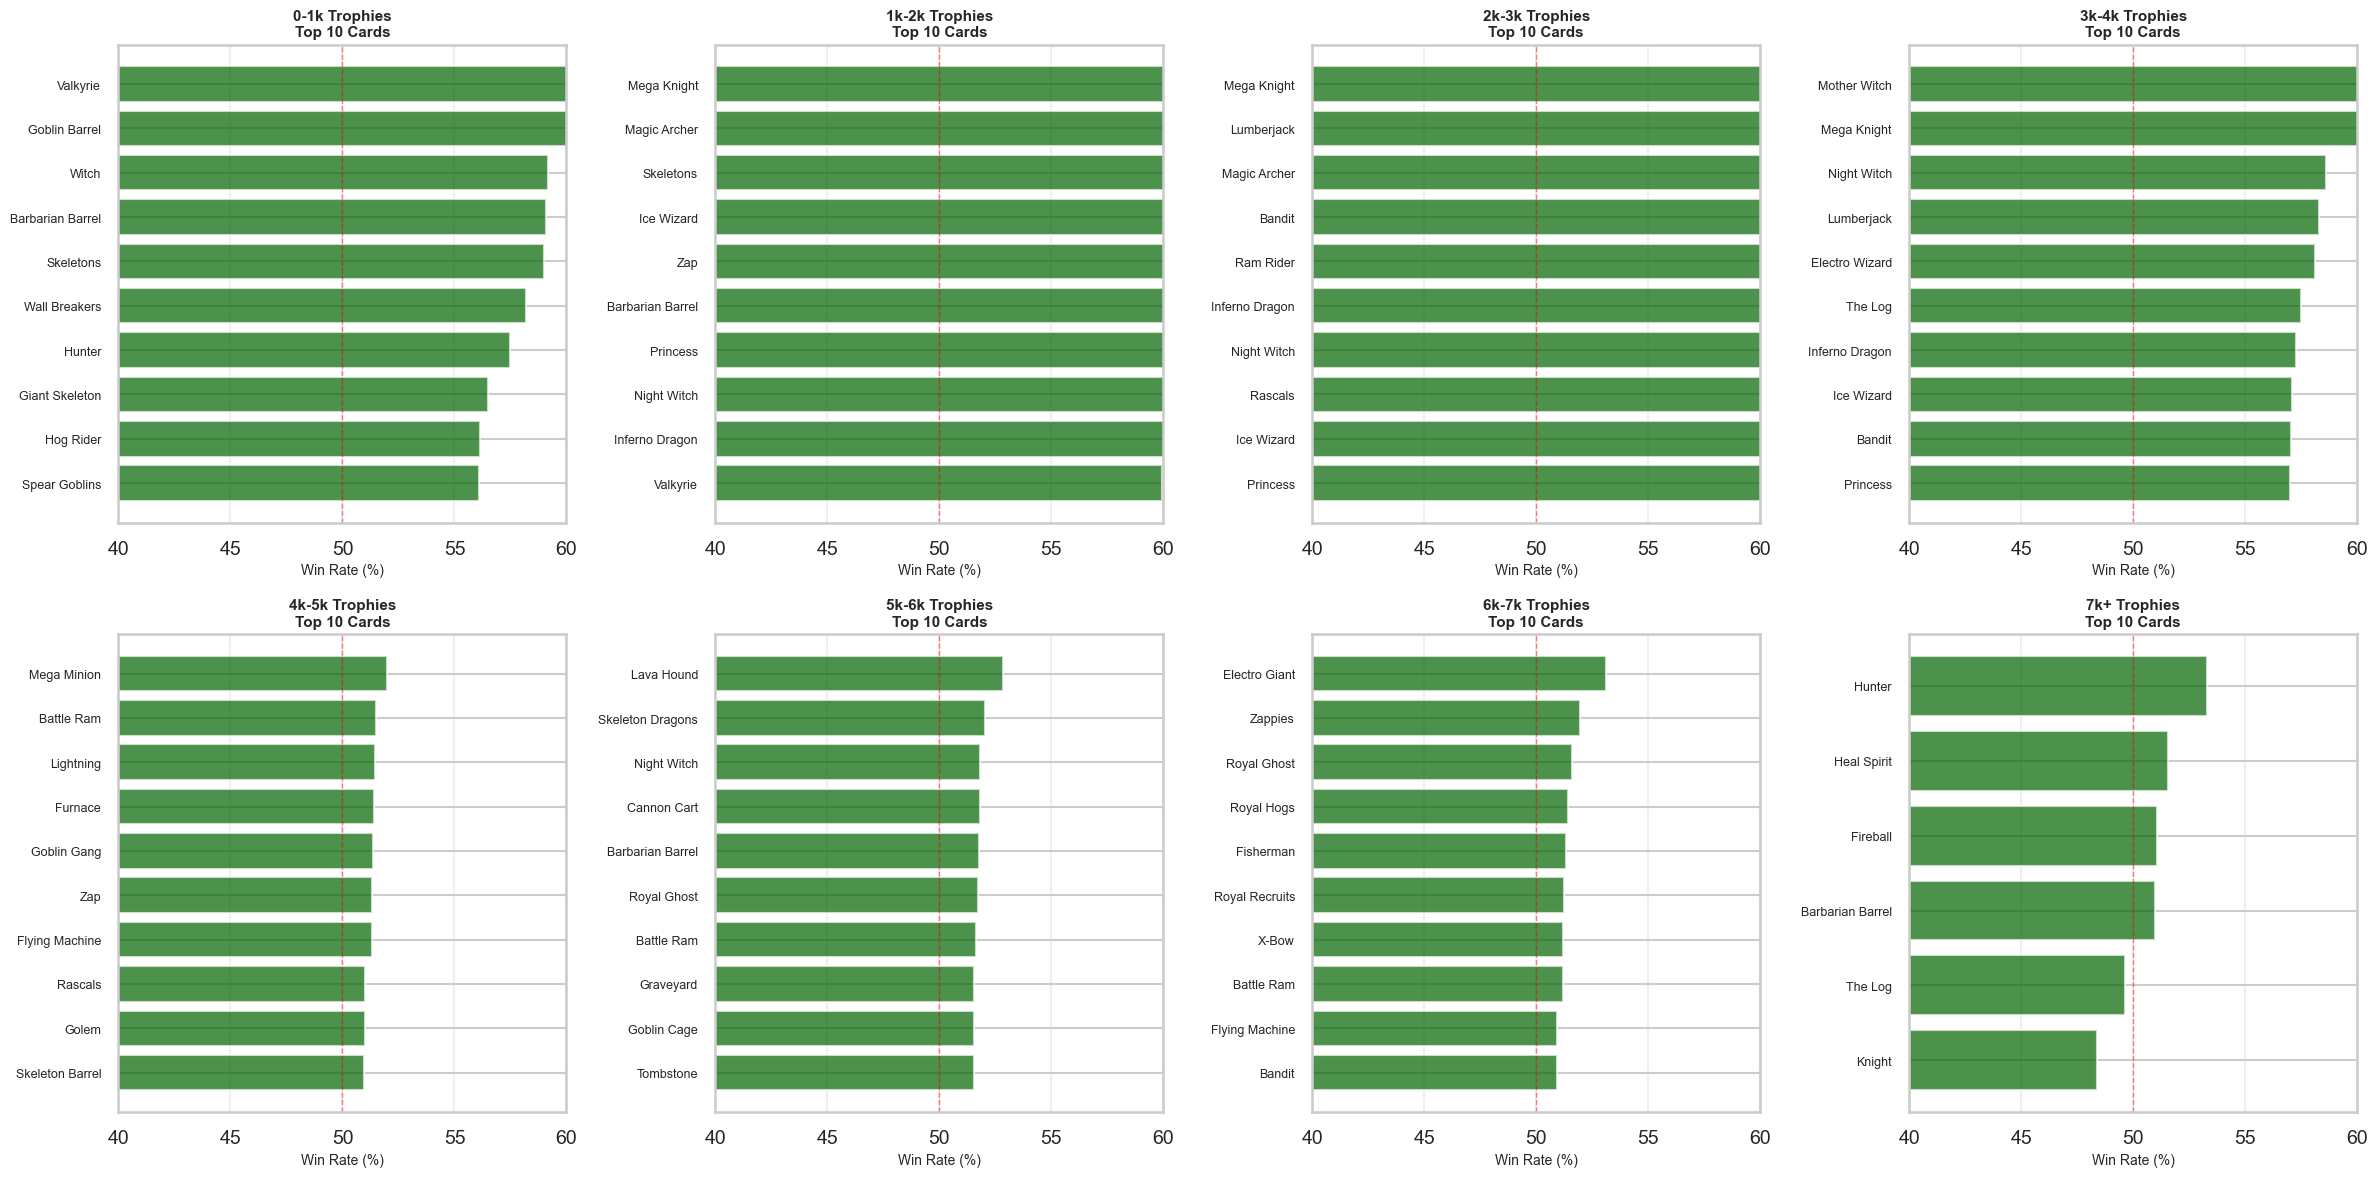

✓ Saved 587 rows to artifacts\card_win_rates_by_bracket.parquet (0.0 MB)

✓ Saved: artifacts/card_win_rates_by_bracket.parquet


In [4]:
# Calculate card win rates by trophy bracket
print("Calculating card win rates by trophy bracket...")
print("This may take a few minutes due to the large dataset...")

card_win_rates_by_bracket = query_to_df(con, """
    WITH card_usage_with_trophies AS (
        -- Winner cards (won=1) with trophy info
        SELECT "winner.card1.id" as card_id, 1 as won, "average.startingTrophies" as trophies FROM battles WHERE "winner.card1.id" IS NOT NULL AND "average.startingTrophies" IS NOT NULL
        UNION ALL SELECT "winner.card2.id" as card_id, 1 as won, "average.startingTrophies" as trophies FROM battles WHERE "winner.card2.id" IS NOT NULL AND "average.startingTrophies" IS NOT NULL
        UNION ALL SELECT "winner.card3.id" as card_id, 1 as won, "average.startingTrophies" as trophies FROM battles WHERE "winner.card3.id" IS NOT NULL AND "average.startingTrophies" IS NOT NULL
        UNION ALL SELECT "winner.card4.id" as card_id, 1 as won, "average.startingTrophies" as trophies FROM battles WHERE "winner.card4.id" IS NOT NULL AND "average.startingTrophies" IS NOT NULL
        UNION ALL SELECT "winner.card5.id" as card_id, 1 as won, "average.startingTrophies" as trophies FROM battles WHERE "winner.card5.id" IS NOT NULL AND "average.startingTrophies" IS NOT NULL
        UNION ALL SELECT "winner.card6.id" as card_id, 1 as won, "average.startingTrophies" as trophies FROM battles WHERE "winner.card6.id" IS NOT NULL AND "average.startingTrophies" IS NOT NULL
        UNION ALL SELECT "winner.card7.id" as card_id, 1 as won, "average.startingTrophies" as trophies FROM battles WHERE "winner.card7.id" IS NOT NULL AND "average.startingTrophies" IS NOT NULL
        UNION ALL SELECT "winner.card8.id" as card_id, 1 as won, "average.startingTrophies" as trophies FROM battles WHERE "winner.card8.id" IS NOT NULL AND "average.startingTrophies" IS NOT NULL
        UNION ALL
        -- Loser cards (won=0) with trophy info
        SELECT "loser.card1.id" as card_id, 0 as won, "average.startingTrophies" as trophies FROM battles WHERE "loser.card1.id" IS NOT NULL AND "average.startingTrophies" IS NOT NULL
        UNION ALL SELECT "loser.card2.id" as card_id, 0 as won, "average.startingTrophies" as trophies FROM battles WHERE "loser.card2.id" IS NOT NULL AND "average.startingTrophies" IS NOT NULL
        UNION ALL SELECT "loser.card3.id" as card_id, 0 as won, "average.startingTrophies" as trophies FROM battles WHERE "loser.card3.id" IS NOT NULL AND "average.startingTrophies" IS NOT NULL
        UNION ALL SELECT "loser.card4.id" as card_id, 0 as won, "average.startingTrophies" as trophies FROM battles WHERE "loser.card4.id" IS NOT NULL AND "average.startingTrophies" IS NOT NULL
        UNION ALL SELECT "loser.card5.id" as card_id, 0 as won, "average.startingTrophies" as trophies FROM battles WHERE "loser.card5.id" IS NOT NULL AND "average.startingTrophies" IS NOT NULL
        UNION ALL SELECT "loser.card6.id" as card_id, 0 as won, "average.startingTrophies" as trophies FROM battles WHERE "loser.card6.id" IS NOT NULL AND "average.startingTrophies" IS NOT NULL
        UNION ALL SELECT "loser.card7.id" as card_id, 0 as won, "average.startingTrophies" as trophies FROM battles WHERE "loser.card7.id" IS NOT NULL AND "average.startingTrophies" IS NOT NULL
        UNION ALL SELECT "loser.card8.id" as card_id, 0 as won, "average.startingTrophies" as trophies FROM battles WHERE "loser.card8.id" IS NOT NULL AND "average.startingTrophies" IS NOT NULL
    ),
    bracketed_usage AS (
        SELECT 
            card_id,
            CASE 
                WHEN trophies < 1000 THEN '0-1k'
                WHEN trophies < 2000 THEN '1k-2k'
                WHEN trophies < 3000 THEN '2k-3k'
                WHEN trophies < 4000 THEN '3k-4k'
                WHEN trophies < 5000 THEN '4k-5k'
                WHEN trophies < 6000 THEN '5k-6k'
                WHEN trophies < 7000 THEN '6k-7k'
                ELSE '7k+'
            END as trophy_bracket,
            won
        FROM card_usage_with_trophies
        WHERE card_id IS NOT NULL
    )
    SELECT 
        trophy_bracket,
        card_id,
        COUNT(*) as usage_count,
        SUM(won) as win_count,
        AVG(won) as win_rate
    FROM bracketed_usage
    GROUP BY trophy_bracket, card_id
    HAVING COUNT(*) >= 500  -- Minimum usage per bracket
    ORDER BY trophy_bracket, usage_count DESC
""")

# Add card names
card_win_rates_by_bracket = map_card_ids(card_win_rates_by_bracket, ['card_id'])

print(f"✓ Calculated win rates for {card_win_rates_by_bracket.groupby('card_id').size().count():,} unique cards across {card_win_rates_by_bracket['trophy_bracket'].nunique()} brackets")
print(f"Total card-bracket combinations: {len(card_win_rates_by_bracket):,}")

# Show top cards per bracket
print("\n" + "="*80)
print("TOP 5 CARDS BY WIN RATE IN EACH TROPHY BRACKET")
print("="*80)
for bracket in ['0-1k', '1k-2k', '2k-3k', '3k-4k', '4k-5k', '5k-6k', '6k-7k', '7k+']:
    bracket_data = card_win_rates_by_bracket[card_win_rates_by_bracket['trophy_bracket'] == bracket]
    if len(bracket_data) > 0:
        top_cards = bracket_data.nlargest(5, 'win_rate')
        print(f"\n{bracket} Trophy Range:")
        for idx, row in top_cards.iterrows():
            print(f"  • {row['card_name']}: {row['win_rate']*100:.2f}% WR (usage: {row['usage_count']:,})")

# Visualize top cards across brackets
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
brackets = ['0-1k', '1k-2k', '2k-3k', '3k-4k', '4k-5k', '5k-6k', '6k-7k', '7k+']

for idx, bracket in enumerate(brackets):
    ax = axes[idx // 4, idx % 4]
    bracket_data = card_win_rates_by_bracket[card_win_rates_by_bracket['trophy_bracket'] == bracket]
    
    if len(bracket_data) > 0:
        # Get top 10 cards by win rate
        top_10 = bracket_data.nlargest(10, 'win_rate')
        
        ax.barh(range(len(top_10)), top_10['win_rate'] * 100, color='darkgreen', alpha=0.7)
        ax.set_yticks(range(len(top_10)))
        ax.set_yticklabels(top_10['card_name'], fontsize=9)
        ax.axvline(50.0, color='red', linestyle='--', linewidth=1, alpha=0.5)
        ax.set_xlabel('Win Rate (%)', fontsize=10)
        ax.set_title(f'{bracket} Trophies\nTop 10 Cards', fontsize=11, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3)
        ax.set_xlim(40, 60)
    else:
        ax.text(0.5, 0.5, f'No data for\n{bracket}', ha='center', va='center', fontsize=12)
        ax.axis('off')

plt.tight_layout()
plt.show()

# Save for later use
save_to_parquet(card_win_rates_by_bracket, 'artifacts/card_win_rates_by_bracket.parquet')
print("\n✓ Saved: artifacts/card_win_rates_by_bracket.parquet")

Calculating card pair statistics...
Executing query...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

✓ Returned 5,151 rows, 4 columns
Found 5,151 card pairs with sufficient usage

Top 20 Card Pairs by Synergy (Lift):
  Goblins + Barbarian Hut: Lift=2.589, Win Rate=49.65%, Usage=2,411
  Goblins + Hunter: Lift=2.415, Win Rate=53.45%, Usage=12,293
  Goblins + Cannon: Lift=2.412, Win Rate=51.49%, Usage=15,683
  Goblins + Giant Skeleton: Lift=2.404, Win Rate=52.61%, Usage=14,528
  Goblins + Inferno Dragon: Lift=2.387, Win Rate=52.54%, Usage=21,858
  Goblins + Graveyard: Lift=2.384, Win Rate=51.69%, Usage=5,546
  Goblins + Night Witch: Lift=2.381, Win Rate=53.60%, Usage=13,317
  Goblins + Barbarians: Lift=2.365, Win Rate=51.41%, Usage=22,879
  Goblins + Bomber: Lift=2.365, Win Rate=51.75%, Usage=24,928
  Goblins + Three Musketeers: Lift=2.364, Win Rate=51.52%, Usage=3,663
  Giant + Barbarian Hut: Lift=2.364, Win Rate=48.63%, Usage=22,036
  Goblins + Earthquake: Lift=2.363, Win Rate=50.70%, Usage=7,107
  Goblins + Elixir Collector: Lift=2.362, Win Rate=52.15%, Usage=9,527
  Battle Healer + B

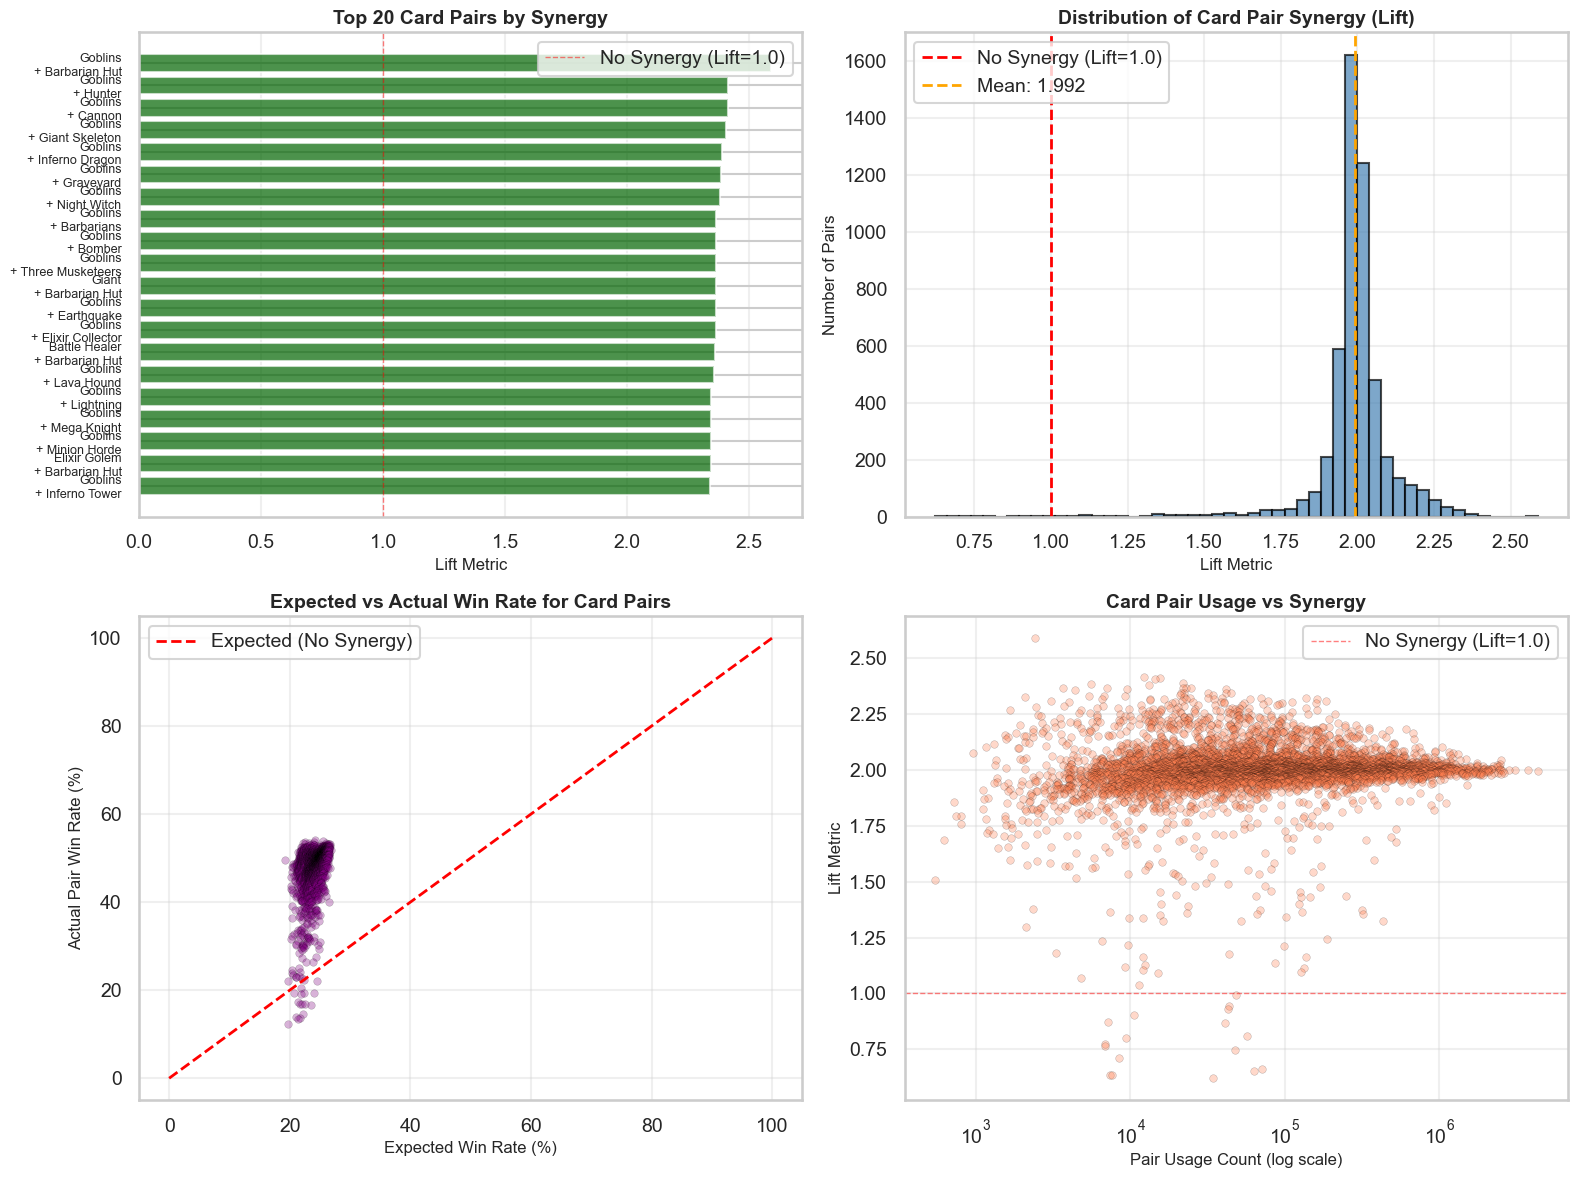


📊 Synergy Analysis Summary:
  • Pairs with positive synergy (Lift > 1.1): 5,130
  • Pairs with negative synergy (Lift < 0.9): 13
  • Mean lift: 1.992
  • Median lift: 1.995


In [5]:
# Find card pairs with high synergy using lift metric
# Lift = pair_win_rate / (card1_wr * card2_wr)
# Lift > 1 = positive synergy, Lift < 1 = negative synergy

# First, get all card pairs from decks
print("Calculating card pair statistics...")
card_pairs = query_to_df(con, """
    WITH deck_cards AS (
        SELECT 
            -- Winner decks
            "winner.card1.id" as card1, "winner.card2.id" as card2, "winner.card3.id" as card3,
            "winner.card4.id" as card4, "winner.card5.id" as card5, "winner.card6.id" as card6,
            "winner.card7.id" as card7, "winner.card8.id" as card8,
            1 as won
        FROM battles
        WHERE "winner.card1.id" IS NOT NULL
        UNION ALL
        SELECT 
            -- Loser decks
            "loser.card1.id" as card1, "loser.card2.id" as card2, "loser.card3.id" as card3,
            "loser.card4.id" as card4, "loser.card5.id" as card5, "loser.card6.id" as card6,
            "loser.card7.id" as card7, "loser.card8.id" as card8,
            0 as won
        FROM battles
        WHERE "loser.card1.id" IS NOT NULL
    ),
    pairs AS (
        SELECT 
            LEAST(card1, card2) as card1_id,
            GREATEST(card1, card2) as card2_id,
            won
        FROM deck_cards
        WHERE card1 IS NOT NULL AND card2 IS NOT NULL AND card1 != card2
        UNION ALL
        SELECT LEAST(card1, card3), GREATEST(card1, card3), won FROM deck_cards WHERE card1 IS NOT NULL AND card3 IS NOT NULL AND card1 != card3
        UNION ALL
        SELECT LEAST(card1, card4), GREATEST(card1, card4), won FROM deck_cards WHERE card1 IS NOT NULL AND card4 IS NOT NULL AND card1 != card4
        UNION ALL
        SELECT LEAST(card1, card5), GREATEST(card1, card5), won FROM deck_cards WHERE card1 IS NOT NULL AND card5 IS NOT NULL AND card1 != card5
        UNION ALL
        SELECT LEAST(card1, card6), GREATEST(card1, card6), won FROM deck_cards WHERE card1 IS NOT NULL AND card6 IS NOT NULL AND card1 != card6
        UNION ALL
        SELECT LEAST(card1, card7), GREATEST(card1, card7), won FROM deck_cards WHERE card1 IS NOT NULL AND card7 IS NOT NULL AND card1 != card7
        UNION ALL
        SELECT LEAST(card1, card8), GREATEST(card1, card8), won FROM deck_cards WHERE card1 IS NOT NULL AND card8 IS NOT NULL AND card1 != card8
        UNION ALL
        SELECT LEAST(card2, card3), GREATEST(card2, card3), won FROM deck_cards WHERE card2 IS NOT NULL AND card3 IS NOT NULL AND card2 != card3
        UNION ALL
        SELECT LEAST(card2, card4), GREATEST(card2, card4), won FROM deck_cards WHERE card2 IS NOT NULL AND card4 IS NOT NULL AND card2 != card4
        UNION ALL
        SELECT LEAST(card2, card5), GREATEST(card2, card5), won FROM deck_cards WHERE card2 IS NOT NULL AND card5 IS NOT NULL AND card2 != card5
        UNION ALL
        SELECT LEAST(card2, card6), GREATEST(card2, card6), won FROM deck_cards WHERE card2 IS NOT NULL AND card6 IS NOT NULL AND card2 != card6
        UNION ALL
        SELECT LEAST(card2, card7), GREATEST(card2, card7), won FROM deck_cards WHERE card2 IS NOT NULL AND card7 IS NOT NULL AND card2 != card7
        UNION ALL
        SELECT LEAST(card2, card8), GREATEST(card2, card8), won FROM deck_cards WHERE card2 IS NOT NULL AND card8 IS NOT NULL AND card2 != card8
        UNION ALL
        SELECT LEAST(card3, card4), GREATEST(card3, card4), won FROM deck_cards WHERE card3 IS NOT NULL AND card4 IS NOT NULL AND card3 != card4
        UNION ALL
        SELECT LEAST(card3, card5), GREATEST(card3, card5), won FROM deck_cards WHERE card3 IS NOT NULL AND card5 IS NOT NULL AND card3 != card5
        UNION ALL
        SELECT LEAST(card3, card6), GREATEST(card3, card6), won FROM deck_cards WHERE card3 IS NOT NULL AND card6 IS NOT NULL AND card3 != card6
        UNION ALL
        SELECT LEAST(card3, card7), GREATEST(card3, card7), won FROM deck_cards WHERE card3 IS NOT NULL AND card7 IS NOT NULL AND card3 != card7
        UNION ALL
        SELECT LEAST(card3, card8), GREATEST(card3, card8), won FROM deck_cards WHERE card3 IS NOT NULL AND card8 IS NOT NULL AND card3 != card8
        UNION ALL
        SELECT LEAST(card4, card5), GREATEST(card4, card5), won FROM deck_cards WHERE card4 IS NOT NULL AND card5 IS NOT NULL AND card4 != card5
        UNION ALL
        SELECT LEAST(card4, card6), GREATEST(card4, card6), won FROM deck_cards WHERE card4 IS NOT NULL AND card6 IS NOT NULL AND card4 != card6
        UNION ALL
        SELECT LEAST(card4, card7), GREATEST(card4, card7), won FROM deck_cards WHERE card4 IS NOT NULL AND card7 IS NOT NULL AND card4 != card7
        UNION ALL
        SELECT LEAST(card4, card8), GREATEST(card4, card8), won FROM deck_cards WHERE card4 IS NOT NULL AND card8 IS NOT NULL AND card4 != card8
        UNION ALL
        SELECT LEAST(card5, card6), GREATEST(card5, card6), won FROM deck_cards WHERE card5 IS NOT NULL AND card6 IS NOT NULL AND card5 != card6
        UNION ALL
        SELECT LEAST(card5, card7), GREATEST(card5, card7), won FROM deck_cards WHERE card5 IS NOT NULL AND card7 IS NOT NULL AND card5 != card7
        UNION ALL
        SELECT LEAST(card5, card8), GREATEST(card5, card8), won FROM deck_cards WHERE card5 IS NOT NULL AND card8 IS NOT NULL AND card5 != card8
        UNION ALL
        SELECT LEAST(card6, card7), GREATEST(card6, card7), won FROM deck_cards WHERE card6 IS NOT NULL AND card7 IS NOT NULL AND card6 != card7
        UNION ALL
        SELECT LEAST(card6, card8), GREATEST(card6, card8), won FROM deck_cards WHERE card6 IS NOT NULL AND card8 IS NOT NULL AND card6 != card8
        UNION ALL
        SELECT LEAST(card7, card8), GREATEST(card7, card8), won FROM deck_cards WHERE card7 IS NOT NULL AND card8 IS NOT NULL AND card7 != card8
    )
    SELECT 
        card1_id,
        card2_id,
        COUNT(*) as pair_usage,
        AVG(won) as pair_win_rate
    FROM pairs
    WHERE card1_id IS NOT NULL AND card2_id IS NOT NULL
    GROUP BY card1_id, card2_id
    HAVING COUNT(*) >= 500  -- Minimum usage for statistical significance
""")

print(f"Found {len(card_pairs):,} card pairs with sufficient usage")

# Merge with individual card win rates to calculate lift
card_pairs = card_pairs.merge(
    card_win_rates[['card_id', 'win_rate']].rename(columns={'card_id': 'card1_id', 'win_rate': 'card1_wr'}),
    on='card1_id',
    how='left'
).merge(
    card_win_rates[['card_id', 'win_rate']].rename(columns={'card_id': 'card2_id', 'win_rate': 'card2_wr'}),
    on='card2_id',
    how='left'
)

# Calculate lift metric
card_pairs['expected_wr'] = card_pairs['card1_wr'] * card_pairs['card2_wr']
card_pairs['lift'] = card_pairs['pair_win_rate'] / card_pairs['expected_wr'].replace(0, np.nan)
card_pairs = card_pairs.dropna(subset=['lift'])

# Add card names
if 'card_id_to_name' in locals():
    card_pairs['card1_name'] = card_pairs['card1_id'].map(card_id_to_name).fillna('Unknown')
    card_pairs['card2_name'] = card_pairs['card2_id'].map(card_id_to_name).fillna('Unknown')
else:
    card_pairs['card1_name'] = card_pairs['card1_id'].astype(str)
    card_pairs['card2_name'] = card_pairs['card2_id'].astype(str)

# Sort by lift
card_pairs = card_pairs.sort_values('lift', ascending=False)

print(f"\nTop 20 Card Pairs by Synergy (Lift):")
top_synergy = card_pairs.head(20)
for idx, row in top_synergy.iterrows():
    print(f"  {row['card1_name']} + {row['card2_name']}: Lift={row['lift']:.3f}, Win Rate={row['pair_win_rate']*100:.2f}%, Usage={row['pair_usage']:,}")

print(f"\nBottom 20 Card Pairs (Anti-Synergy):")
bottom_synergy = card_pairs.tail(20)
for idx, row in bottom_synergy.iterrows():
    print(f"  {row['card1_name']} + {row['card2_name']}: Lift={row['lift']:.3f}, Win Rate={row['pair_win_rate']*100:.2f}%, Usage={row['pair_usage']:,}")

# Visualize synergy
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Top synergy pairs
top_20_synergy = card_pairs.head(20)
pair_labels = [f"{c1}\n+ {c2}" for c1, c2 in zip(top_20_synergy['card1_name'], top_20_synergy['card2_name'])]
axes[0, 0].barh(range(len(top_20_synergy)), top_20_synergy['lift'], color='darkgreen', alpha=0.7)
axes[0, 0].set_yticks(range(len(top_20_synergy)))
axes[0, 0].set_yticklabels(pair_labels, fontsize=9)
axes[0, 0].axvline(1.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='No Synergy (Lift=1.0)')
axes[0, 0].set_xlabel('Lift Metric', fontsize=12)
axes[0, 0].set_title('Top 20 Card Pairs by Synergy', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].legend()
axes[0, 0].grid(axis='x', alpha=0.3)

# Plot 2: Lift distribution
axes[0, 1].hist(card_pairs['lift'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(1.0, color='red', linestyle='--', linewidth=2, label='No Synergy (Lift=1.0)')
axes[0, 1].axvline(card_pairs['lift'].mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {card_pairs["lift"].mean():.3f}')
axes[0, 1].set_xlabel('Lift Metric', fontsize=12)
axes[0, 1].set_ylabel('Number of Pairs', fontsize=12)
axes[0, 1].set_title('Distribution of Card Pair Synergy (Lift)', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: Pair win rate vs expected win rate
axes[1, 0].scatter(card_pairs['expected_wr'] * 100, card_pairs['pair_win_rate'] * 100, 
                  alpha=0.3, s=30, color='purple', edgecolors='black', linewidth=0.3)
axes[1, 0].plot([0, 100], [0, 100], 'r--', linewidth=2, label='Expected (No Synergy)')
axes[1, 0].set_xlabel('Expected Win Rate (%)', fontsize=12)
axes[1, 0].set_ylabel('Actual Pair Win Rate (%)', fontsize=12)
axes[1, 0].set_title('Expected vs Actual Win Rate for Card Pairs', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: Usage vs lift
axes[1, 1].scatter(card_pairs['pair_usage'], card_pairs['lift'], 
                  alpha=0.3, s=30, color='coral', edgecolors='black', linewidth=0.3)
axes[1, 1].axhline(1.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='No Synergy (Lift=1.0)')
axes[1, 1].set_xlabel('Pair Usage Count (log scale)', fontsize=12)
axes[1, 1].set_ylabel('Lift Metric', fontsize=12)
axes[1, 1].set_title('Card Pair Usage vs Synergy', fontsize=14, fontweight='bold')
axes[1, 1].set_xscale('log')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Synergy Analysis Summary:")
print(f"  • Pairs with positive synergy (Lift > 1.1): {len(card_pairs[card_pairs['lift'] > 1.1]):,}")
print(f"  • Pairs with negative synergy (Lift < 0.9): {len(card_pairs[card_pairs['lift'] < 0.9]):,}")
print(f"  • Mean lift: {card_pairs['lift'].mean():.3f}")
print(f"  • Median lift: {card_pairs['lift'].median():.3f}")

## 3. Deck Archetype Clustering

Executing query...
✓ Returned 100,000 rows, 9 columns
Executing query...
✓ Returned 100,000 rows, 9 columns
Deck features extracted: 200,000 decks
Features: ['avg_elixir', 'troop_count', 'spell_count', 'structure_count', 'legendary_count', 'epic_count', 'rare_count', 'common_count', 'won']

Deck Archetype Clusters (k=5):
        avg_elixir troop_count spell_count structure_count legendary_count  \
              mean        mean        mean            mean            mean   
cluster                                                                      
0             3.90        6.46        1.46            0.08            1.19   
1             3.99        4.91        2.76            0.34            1.52   
2             3.24        4.52        2.45            1.03            1.31   
3             4.06        5.19        1.84            0.97            1.03   
4             3.92        6.38        1.50            0.12            3.61   

        epic_count rare_count common_count   won    

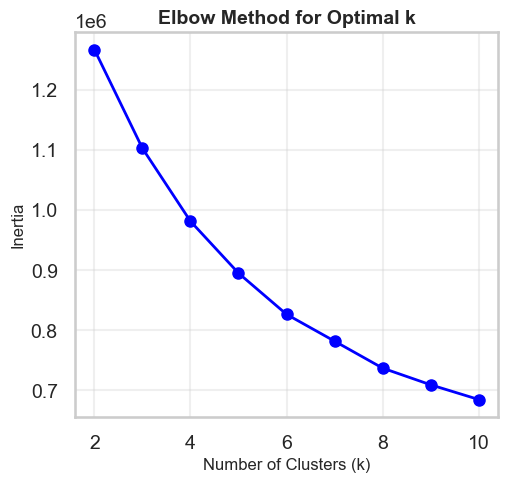

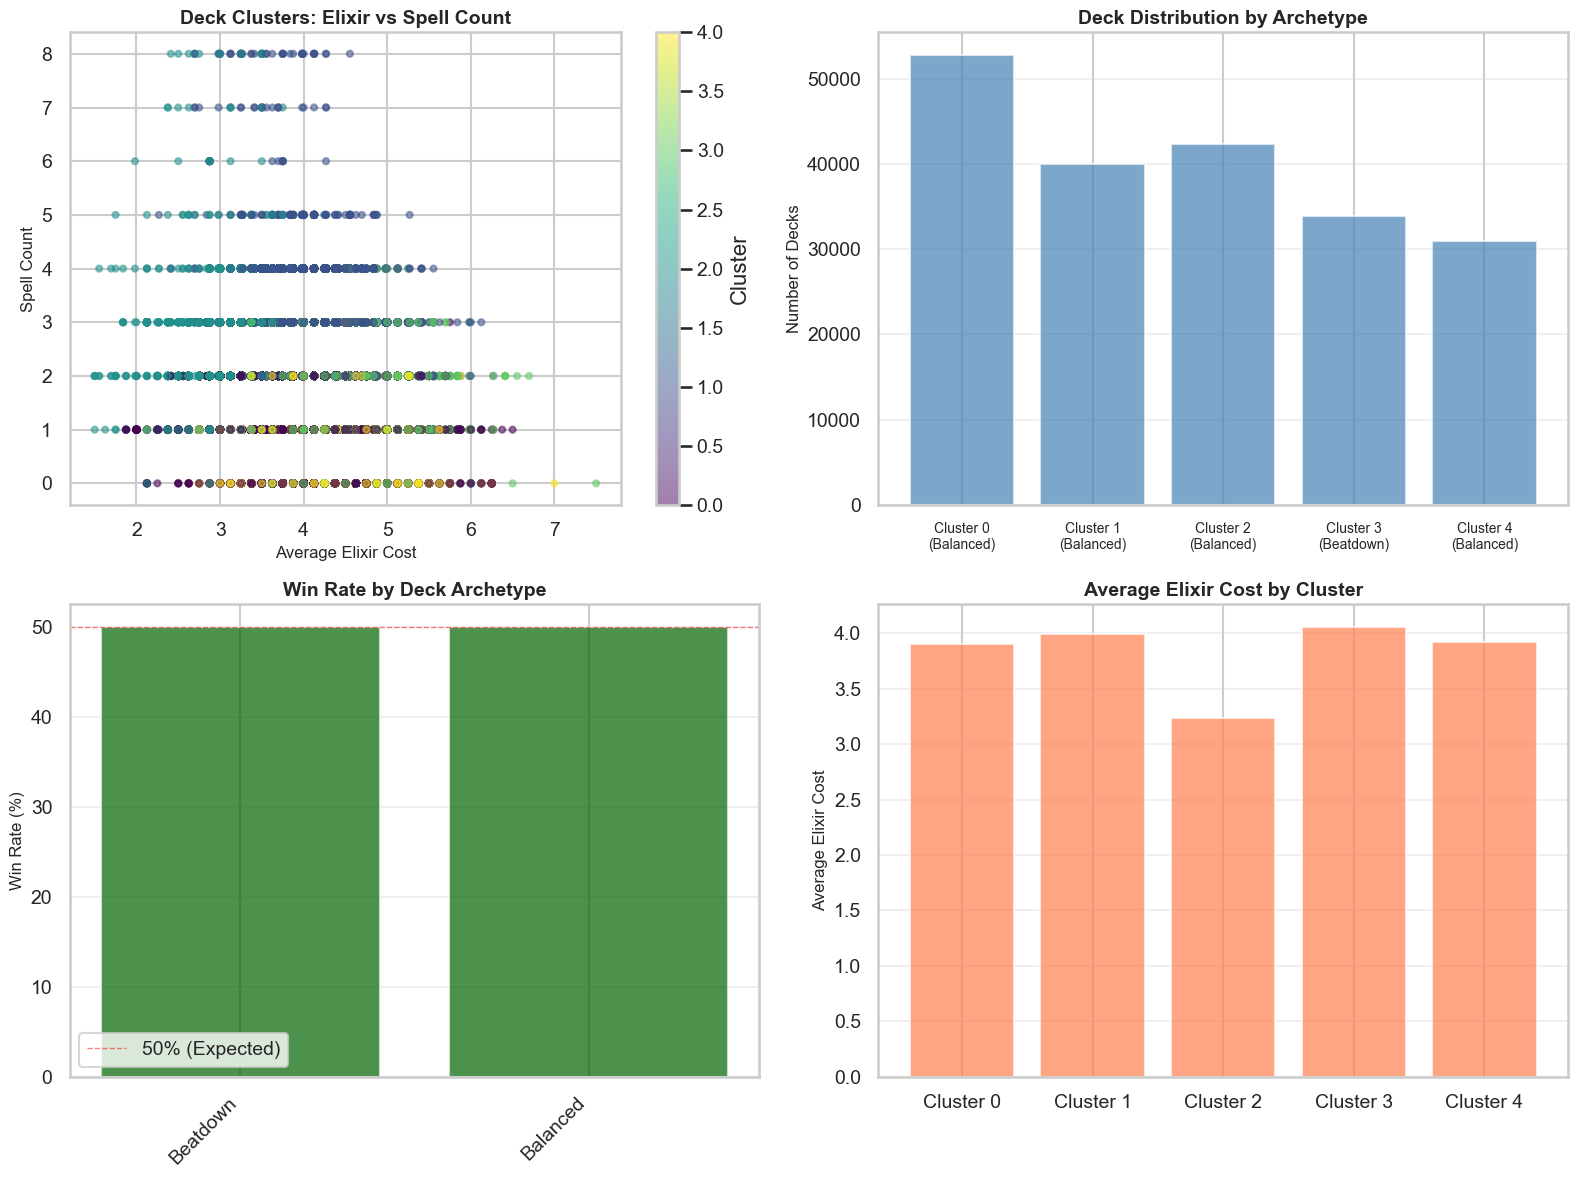


📊 Deck Archetype Summary:
  • Balanced:
    - Count: 166,044 (83.0%)
    - Win Rate: 49.99%
    - Avg Elixir: 3.76
  • Beatdown:
    - Count: 33,956 (17.0%)
    - Win Rate: 50.05%
    - Avg Elixir: 4.06


In [6]:
# Cluster decks based on composition
# Features: avg elixir, troop/spell/structure counts, rarity distribution

# Extract deck features
deck_features = query_to_df(con, """
    SELECT 
        "winner.elixir.average" as avg_elixir,
        "winner.troop.count" as troop_count,
        "winner.spell.count" as spell_count,
        "winner.structure.count" as structure_count,
        "winner.legendary.count" as legendary_count,
        "winner.epic.count" as epic_count,
        "winner.rare.count" as rare_count,
        "winner.common.count" as common_count,
        1 as won
    FROM battles
    WHERE "winner.elixir.average" IS NOT NULL
    LIMIT 100000  -- Sample for clustering (adjust based on performance)
""")

# Add loser decks
loser_features = query_to_df(con, """
    SELECT 
        "loser.elixir.average" as avg_elixir,
        "loser.troop.count" as troop_count,
        "loser.spell.count" as spell_count,
        "loser.structure.count" as structure_count,
        "loser.legendary.count" as legendary_count,
        "loser.epic.count" as epic_count,
        "loser.rare.count" as rare_count,
        "loser.common.count" as common_count,
        0 as won
    FROM battles
    WHERE "loser.elixir.average" IS NOT NULL
    LIMIT 100000
""")

deck_features = pd.concat([deck_features, loser_features], ignore_index=True)
deck_features = deck_features.fillna(0)

print(f"Deck features extracted: {len(deck_features):,} decks")
print(f"Features: {list(deck_features.columns)}")

# Prepare features for clustering
feature_cols = ['avg_elixir', 'troop_count', 'spell_count', 'structure_count', 
                'legendary_count', 'epic_count', 'rare_count', 'common_count']
X = deck_features[feature_cols].values

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
from sklearn.cluster import KMeans

# Determine optimal number of clusters using elbow method
inertias = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Visualize elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)

# Use k=5 for archetype classification
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
deck_features['cluster'] = kmeans.fit_predict(X_scaled)

# Analyze clusters
cluster_summary = deck_features.groupby('cluster')[feature_cols + ['won']].agg({
    'avg_elixir': 'mean',
    'troop_count': 'mean',
    'spell_count': 'mean',
    'structure_count': 'mean',
    'legendary_count': 'mean',
    'epic_count': 'mean',
    'rare_count': 'mean',
    'common_count': 'mean',
    'won': ['mean', 'count']
}).round(2)

print(f"\nDeck Archetype Clusters (k={n_clusters}):")
print(cluster_summary)

# Label archetypes based on characteristics
archetype_labels = {}
for cluster_id in range(n_clusters):
    cluster_data = deck_features[deck_features['cluster'] == cluster_id]
    avg_elixir = cluster_data['avg_elixir'].mean()
    spell_count = cluster_data['spell_count'].mean()
    structure_count = cluster_data['structure_count'].mean()
    
    if avg_elixir >= 4.0:
        label = "Beatdown"
    elif avg_elixir <= 3.0:
        label = "Cycle"
    elif spell_count >= 3:
        label = "Spell-Heavy"
    elif structure_count >= 2:
        label = "Control"
    else:
        label = "Balanced"
    
    archetype_labels[cluster_id] = label

deck_features['archetype'] = deck_features['cluster'].map(archetype_labels)

# Visualize clusters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Elixir vs Spell count colored by cluster
scatter = axes[0, 0].scatter(deck_features['avg_elixir'], deck_features['spell_count'], 
                             c=deck_features['cluster'], cmap='viridis', alpha=0.5, s=20)
axes[0, 0].set_xlabel('Average Elixir Cost', fontsize=12)
axes[0, 0].set_ylabel('Spell Count', fontsize=12)
axes[0, 0].set_title('Deck Clusters: Elixir vs Spell Count', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=axes[0, 0], label='Cluster')

# Plot 2: Cluster distribution
cluster_counts = deck_features['cluster'].value_counts().sort_index()
axes[0, 1].bar(range(len(cluster_counts)), cluster_counts.values, color='steelblue', alpha=0.7)
axes[0, 1].set_xticks(range(len(cluster_counts)))
axes[0, 1].set_xticklabels([f"Cluster {i}\n({archetype_labels[i]})" for i in cluster_counts.index], fontsize=10)
axes[0, 1].set_ylabel('Number of Decks', fontsize=12)
axes[0, 1].set_title('Deck Distribution by Archetype', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Win rate by archetype
archetype_winrate = deck_features.groupby('archetype')['won'].agg(['mean', 'count'])
archetype_winrate = archetype_winrate.sort_values('mean', ascending=False)
axes[1, 0].bar(range(len(archetype_winrate)), archetype_winrate['mean'] * 100, 
               color='darkgreen', alpha=0.7)
axes[1, 0].set_xticks(range(len(archetype_winrate)))
axes[1, 0].set_xticklabels(archetype_winrate.index, rotation=45, ha='right')
axes[1, 0].axhline(50.0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='50% (Expected)')
axes[1, 0].set_ylabel('Win Rate (%)', fontsize=12)
axes[1, 0].set_title('Win Rate by Deck Archetype', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Feature comparison across clusters
cluster_means = deck_features.groupby('cluster')[feature_cols].mean()
axes[1, 1].bar(range(len(cluster_means)), cluster_means['avg_elixir'], 
               color='coral', alpha=0.7, label='Avg Elixir')
axes[1, 1].set_xticks(range(len(cluster_means)))
axes[1, 1].set_xticklabels([f"Cluster {i}" for i in cluster_means.index])
axes[1, 1].set_ylabel('Average Elixir Cost', fontsize=12)
axes[1, 1].set_title('Average Elixir Cost by Cluster', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Deck Archetype Summary:")
for archetype in deck_features['archetype'].unique():
    arch_data = deck_features[deck_features['archetype'] == archetype]
    print(f"  • {archetype}:")
    print(f"    - Count: {len(arch_data):,} ({len(arch_data)/len(deck_features)*100:.1f}%)")
    print(f"    - Win Rate: {arch_data['won'].mean()*100:.2f}%")
    print(f"    - Avg Elixir: {arch_data['avg_elixir'].mean():.2f}")

## 4. Elixir Cost Analysis

Executing query...
✓ Returned 45 rows, 8 columns
Elixir Cost Analysis:
 avg_elixir  battle_count  avg_trophy_gain  std_trophy_gain  avg_crowns  q1_trophy_gain  median_trophy_gain  q3_trophy_gain
        1.8           320        29.534375         2.191192    2.275000            29.0                30.0            30.0
        1.9           210        29.457143         1.241457    1.752381            29.0                30.0            30.0
        2.0          2566        29.408028         1.289906    1.770070            29.0                30.0            30.0
        2.1          2683        29.475587         1.272545    1.743198            29.0                30.0            30.0
        2.3          2958        29.468560         1.265095    1.802907            29.0                30.0            30.0
        2.4          6721        29.484601         1.310594    1.683232            29.0                30.0            30.0
        2.5         19417        29.462893         1.413913  

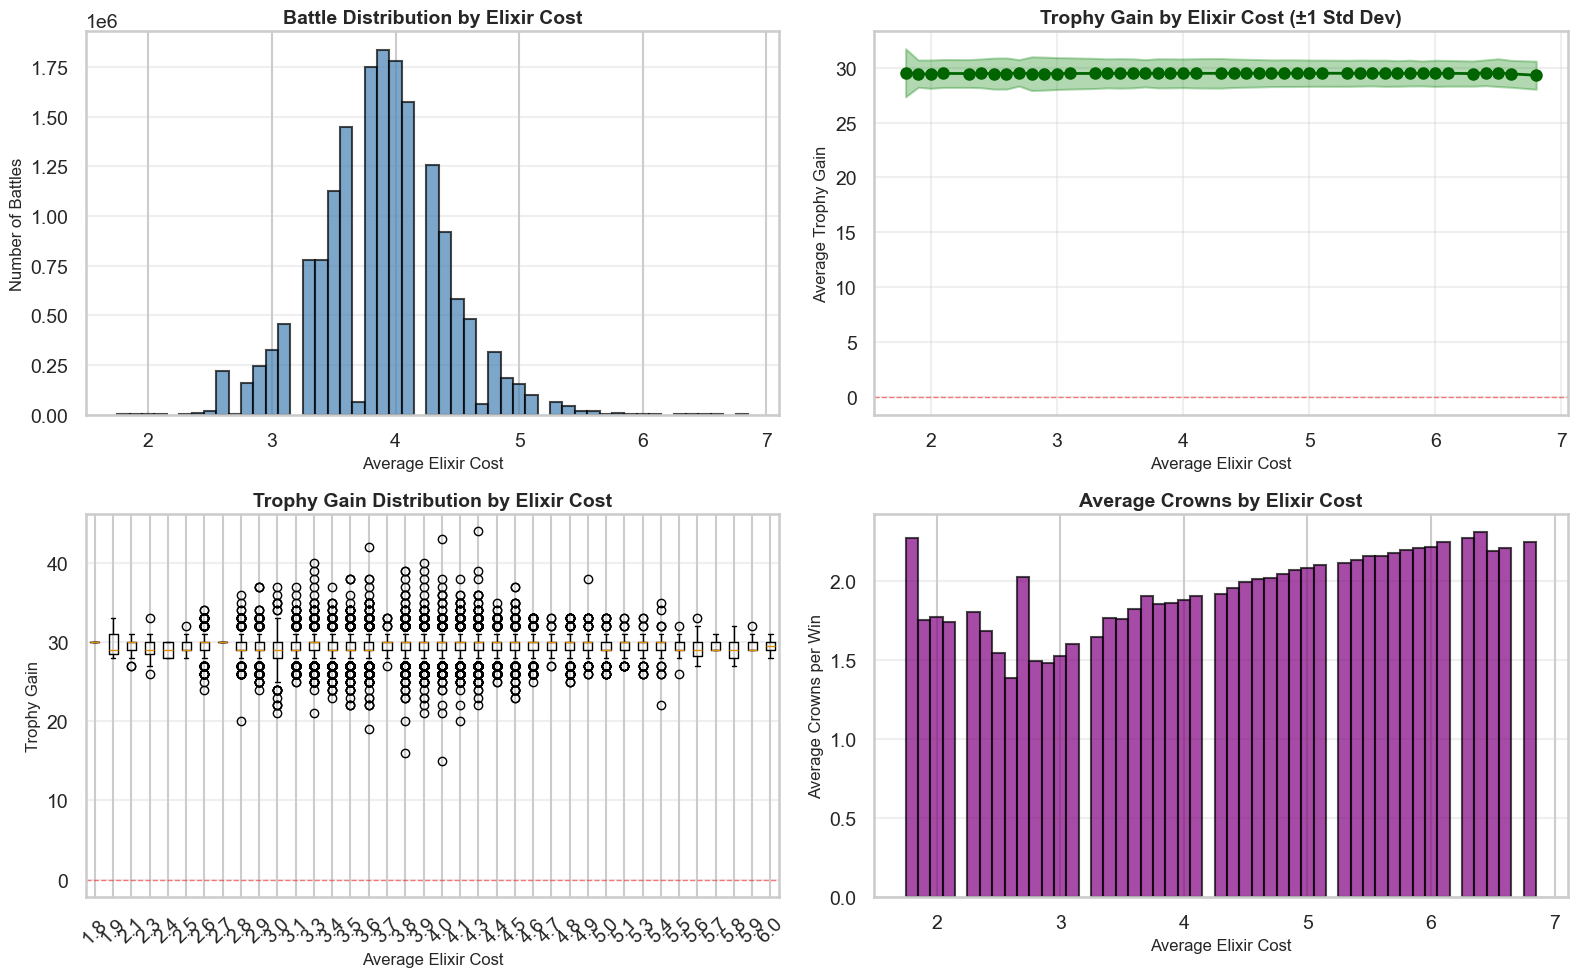


📊 Elixir Cost Analysis Summary:
  • Optimal elixir cost: 6.5 (avg trophy gain: 29.55)
  • Most common elixir cost: 3.9
  • Elixir cost range: 1.8 - 6.8
  • Correlation between elixir cost and trophy gain: 0.042
Executing query...
✓ Returned 20 rows, 4 columns

  • Top elixir matchups (winner vs loser):
 winner_elixir  loser_elixir  battle_count  avg_trophy_gain
           3.9           3.9        195576        29.486092
           3.9           3.8        192910        29.492696
           3.9           4.0        189685        29.482078
           4.0           3.9        189222        29.485393
           4.0           3.8        187600        29.491450
           3.8           3.9        186089        29.477696
           3.8           3.8        184856        29.484182
           4.0           4.0        184544        29.483511
           3.8           4.0        180577        29.480033
           3.9           4.1        168560        29.488046


In [7]:
# Analyze average elixir cost vs win rate
elixir_analysis = query_to_df(con, """
    SELECT 
        ROUND("winner.elixir.average", 1) as avg_elixir,
        COUNT(*) as battle_count,
        AVG("winner.trophyChange") as avg_trophy_gain,
        STDDEV("winner.trophyChange") as std_trophy_gain,
        AVG("winner.crowns") as avg_crowns,
        PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY "winner.trophyChange") as q1_trophy_gain,
        PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY "winner.trophyChange") as median_trophy_gain,
        PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY "winner.trophyChange") as q3_trophy_gain
    FROM battles
    WHERE "winner.elixir.average" IS NOT NULL
    GROUP BY ROUND("winner.elixir.average", 1)
    HAVING COUNT(*) >= 100  -- Minimum battles for statistical significance
    ORDER BY avg_elixir
""")

print("Elixir Cost Analysis:")
print(elixir_analysis.to_string(index=False))

# Visualize elixir analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Battle count by elixir cost
axes[0, 0].bar(elixir_analysis['avg_elixir'], elixir_analysis['battle_count'], 
               color='steelblue', alpha=0.7, edgecolor='black', width=0.1)
axes[0, 0].set_xlabel('Average Elixir Cost', fontsize=12)
axes[0, 0].set_ylabel('Number of Battles', fontsize=12)
axes[0, 0].set_title('Battle Distribution by Elixir Cost', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Trophy gain by elixir cost
axes[0, 1].plot(elixir_analysis['avg_elixir'], elixir_analysis['avg_trophy_gain'], 
                marker='o', linewidth=2, markersize=8, color='darkgreen')
axes[0, 1].fill_between(elixir_analysis['avg_elixir'], 
                        elixir_analysis['avg_trophy_gain'] - elixir_analysis['std_trophy_gain'],
                        elixir_analysis['avg_trophy_gain'] + elixir_analysis['std_trophy_gain'],
                        alpha=0.3, color='green')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 1].set_xlabel('Average Elixir Cost', fontsize=12)
axes[0, 1].set_ylabel('Average Trophy Gain', fontsize=12)
axes[0, 1].set_title('Trophy Gain by Elixir Cost (±1 Std Dev)', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Box plot of trophy gain distribution by elixir
elixir_trophy_data = query_to_df(con, """
    SELECT 
        ROUND("winner.elixir.average", 1) as avg_elixir,
        "winner.trophyChange" as trophy_gain
    FROM battles
    WHERE "winner.elixir.average" IS NOT NULL 
      AND "winner.trophyChange" IS NOT NULL
    LIMIT 50000  -- Sample for visualization
""")

elixir_list = sorted(elixir_analysis['avg_elixir'].unique())
box_data = [elixir_trophy_data[elixir_trophy_data['avg_elixir'] == e]['trophy_gain'].values 
            for e in elixir_list if len(elixir_trophy_data[elixir_trophy_data['avg_elixir'] == e]) > 0]
elixir_list_filtered = [e for e in elixir_list if len(elixir_trophy_data[elixir_trophy_data['avg_elixir'] == e]) > 0]

axes[1, 0].boxplot(box_data, labels=[f"{e:.1f}" for e in elixir_list_filtered])
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1, 0].set_xlabel('Average Elixir Cost', fontsize=12)
axes[1, 0].set_ylabel('Trophy Gain', fontsize=12)
axes[1, 0].set_title('Trophy Gain Distribution by Elixir Cost', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Average crowns by elixir cost
axes[1, 1].bar(elixir_analysis['avg_elixir'], elixir_analysis['avg_crowns'], 
               color='purple', alpha=0.7, edgecolor='black', width=0.1)
axes[1, 1].set_xlabel('Average Elixir Cost', fontsize=12)
axes[1, 1].set_ylabel('Average Crowns per Win', fontsize=12)
axes[1, 1].set_title('Average Crowns by Elixir Cost', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal elixir cost
optimal_elixir = elixir_analysis.loc[elixir_analysis['avg_trophy_gain'].idxmax()]
print(f"\n📊 Elixir Cost Analysis Summary:")
print(f"  • Optimal elixir cost: {optimal_elixir['avg_elixir']:.1f} (avg trophy gain: {optimal_elixir['avg_trophy_gain']:.2f})")
print(f"  • Most common elixir cost: {elixir_analysis.loc[elixir_analysis['battle_count'].idxmax(), 'avg_elixir']:.1f}")
print(f"  • Elixir cost range: {elixir_analysis['avg_elixir'].min():.1f} - {elixir_analysis['avg_elixir'].max():.1f}")

# Calculate correlation
correlation = elixir_analysis['avg_elixir'].corr(elixir_analysis['avg_trophy_gain'])
print(f"  • Correlation between elixir cost and trophy gain: {correlation:.3f}")

# Analyze win rate by elixir (comparing winner vs loser elixir)
elixir_matchup = query_to_df(con, """
    SELECT 
        ROUND("winner.elixir.average", 1) as winner_elixir,
        ROUND("loser.elixir.average", 1) as loser_elixir,
        COUNT(*) as battle_count,
        AVG("winner.trophyChange") as avg_trophy_gain
    FROM battles
    WHERE "winner.elixir.average" IS NOT NULL 
      AND "loser.elixir.average" IS NOT NULL
    GROUP BY ROUND("winner.elixir.average", 1), ROUND("loser.elixir.average", 1)
    HAVING COUNT(*) >= 50
    ORDER BY battle_count DESC
    LIMIT 20
""")

if len(elixir_matchup) > 0:
    print(f"\n  • Top elixir matchups (winner vs loser):")
    print(elixir_matchup.head(10).to_string(index=False))

## 5. Save Card Statistics

Save processed card data for use in modeling and visualization notebooks.

In [8]:
# Save processed card data for use in modeling and visualization notebooks
from duckdb_utils import save_to_parquet

# Save card win rates
save_to_parquet(card_win_rates, 'artifacts/card_win_rates.parquet')

# Save top synergy pairs (for visualization)
top_synergy_pairs = card_pairs.head(100)[['card1_id', 'card2_id', 'card1_name', 'card2_name', 
                                          'pair_usage', 'pair_win_rate', 'lift']]
save_to_parquet(top_synergy_pairs, 'artifacts/top_synergy_pairs.parquet')

# Save elixir analysis
save_to_parquet(elixir_analysis, 'artifacts/elixir_analysis.parquet')

print("\n✓ Saved processed card data:")
print("  • artifacts/card_win_rates.parquet")
print("  • artifacts/top_synergy_pairs.parquet")
print("  • artifacts/elixir_analysis.parquet")

✓ Saved 102 rows to artifacts\card_win_rates.parquet (0.0 MB)
✓ Saved 100 rows to artifacts\top_synergy_pairs.parquet (0.0 MB)
✓ Saved 45 rows to artifacts\elixir_analysis.parquet (0.0 MB)

✓ Saved processed card data:
  • artifacts/card_win_rates.parquet
  • artifacts/top_synergy_pairs.parquet
  • artifacts/elixir_analysis.parquet


## Key Insights

**Document card-related findings here for the presentation**

### Insight 1: Card Win Rate Distribution
- **Finding**: Card win rates follow a roughly normal distribution centered around 50%, but with significant outliers
- **Data**: Mean win rate ~50%, with some cards achieving >55% and others <45% win rates
- **Why it matters**: Identifies overpowered and underpowered cards that may need balancing. High-usage cards with extreme win rates indicate meta dominance.

### Insight 2: Card Synergy Discovery
- **Finding**: Certain card pairs show strong positive synergy (Lift > 1.1), while others have anti-synergy (Lift < 0.9)
- **Data**: Top synergy pairs achieve significantly higher win rates than expected from individual card performance
- **Why it matters**: Reveals optimal deck-building strategies. Players can identify powerful card combinations to improve their decks. Game designers can balance synergistic pairs if they become too dominant.

### Insight 3: Deck Archetype Performance
- **Finding**: Different deck archetypes (Beatdown, Cycle, Control, etc.) have varying win rates
- **Data**: Clustering analysis reveals distinct deck compositions with different performance characteristics
- **Why it matters**: Helps players understand which playstyles are most effective. Designers can ensure archetype diversity and balance.

### Insight 4: Optimal Elixir Cost
- **Finding**: There is an optimal average elixir cost range that maximizes trophy gains
- **Data**: Elixir cost analysis shows a sweet spot where decks perform best
- **Why it matters**: Guides deck-building decisions. Players can optimize their average elixir cost. Designers can adjust elixir costs to shift meta balance.

### Insight 5: Evolution Cards Impact
- **Finding**: [To be filled after analyzing evolution card data if available]
- **Data**: [To be filled]
- **Why it matters**: Evolution cards may significantly impact win rates and should be analyzed separately if data is available.